# Overfitting (overconfidence) vs cofidence

## What is Overfitting?

According to Wikipedia: In overfitting, a statistical model describes random error or noise instead of the underlying relationship. Overfitting occurs when a model is **excessively complex**, such as having too many parameters relative to the number of observations. A model that has been overfitted has **poor predictive performance**, as it overreacts to minor fluctuations in the training data. 

In a supervised setting, such overfit model gives significantly high importance to what it has seen during the training, and doesn't generalize well during a test or when it is actually deployed. Particularly, we observe deceivingly high training accuracy, but upsettingly low test accuracy (deployment performance). For example, in image classification problem, the model which has been overfitted learns training images so well that it is hard to distinguish learning from blindly remembering! Moreover, it gets extremely certain about what a particular class looks like, which sadly is not too different from what it has learned (or better call it remembered) during the training phase. This isn't a desirable property; when presented with 1K or 10K images of cats and dogs, we don't want it to just remember that only those set of pixels or group of pixels represent a cat or a dog class, and a slightest deviation from it is something else. This isn't learning, it is more or less remembering; it is important to understanad the difference between these two terms. Remembering can be thought of as just copying, whereas learning is the ability to extract meaningful patterns or abstract concepts that generalize well. 

Overfit models pick up even the silliest details of a class, and noise which aren't respresentative of the general description of that class. As a result, such model assigns high class score (probability value) to only those images which are identical or very close to one of the training images. For example, it assigns high class score to training images, whereas a very low class score when the same image is perturbed a little (e.g., few pixels are brighter or darker than the original image), resulting in classification error. This is very impracticle, as there can be lot of variations in class images such as those due to various scales, viewpoints, deformatioms, illuminations, or intra-class variance. Many of these variations are inherent to a particular class, more precisely the image of it, and it is highly unlikely that such model would be tolerent against all such variations let alone issues like partial observation and other unpredicted distortions. We can say that the model is over-confident about its own understanding. 

The image below shows the difference between class boundaries resulting from an overfit model and a good one (better generalization). The green squiggly line represents a decision boundary resulting from an overfit model. As we can see, it doesn't seem to have captured a true relationship between explanatory variables (x & y axis variables) and the response (blue or red class). In contrast, the black line seems a more reasonable estimate of the true relationship. The green one will definitely perform better over the training input, however, for unseen data it is unlikely to perform better compared to the black one. 

<img src="https://upload.wikimedia.org/wikipedia/commons/1/19/Overfitting.svg"/>
<center>Image by Ignacio Icke, distributed under a [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/)</center>


### Overfitting in Neural Networks

Artificial Neural Networks are prone to overfitting, and there are many ways to fight it. In fact, this is one of the great challenges of deep learning and neural networks. There are many regularization methods: L1 (lasso regression), L2 (ridge regression) terms, and Maxnorm, which penalize the larger weights so they don't grow too large; DropOut, DropConnect, and Maxout techniques make neural nets disregard certain nodes or connections during forward propagation in order to reduce overfitting, by taking average (ensemble) of different models. 


## Confidence

Where does confidence come in the picture? So far, we have seen that our enemy is overfitting i.e. over-confidence. There are various regularization techniques that can help our models stay away from overfitting the training data. Here is the intuition that might explain the notion of confidence in neural networks. In a supervised (human-human teaching) setting, let's suppose you are asked to believe/learn that horses have 3 tails. Would you easily accept it? Or would you reject it up front? Or would you be surprised and then argue endlessly? Now let's further suppose that you are “forced” to believe that it is a fact. Would that change your own (neuronal) understanding about the horse object? Absolutely no; more likely you will create an association of horse object with the so called 3 tailed horse in your brain (and also the belief that you still need to work a lot before you accept this to be true for all the horses). In addition to that, you might also remember this event because it was totally counterintuitive, bizarre, and to some extent a funny experience of your life. It might also be the case that whenever you think about horses in future, you will recollect about this funny incident via association horse->3 tailed-> utter nonsense :) The upshot of this experiment is to show that how certain we are about basic things or concepts most of the time, and it is almost impossible to change our belief about such fundamental things that we have learned in past very well (at least we believe so) unless something crazy is happening with the world e.g., unanimous consensus that we are actually living in the Matrix world; whatever we have learned is just an illusion, and there’s some new finding that horses, in reality, do have three tails. Assuming that it is not the case, your "confidence" could definitely help you – not learn wrong things! 

A wise man shouldn't be excessively certain about anything. However, for simple concepts we all (I believe wise men too) are actually very certain–99.99 ish maybe, because we have observed such concepts repeatedly many a times in our life and also confirmed through other associations. This confidence help us stay sane, and not spend time re-learning or re-exploring concepts which are trivial (according to our understanding. Is it trivial because we have seen few horses and read about them in books and seen them in a couple of movies? Hmm.. not a foolproof fact finding procedure I must say). Such notion of confidence is absent in Neural Networks. More explanation..


Hey vsauce?
- How certain we are about simple concepts actually? distribution of this certainty over population? 
- How many time is many when we talk about certainty of belief?

## Experiment 

Using class visualization technique, we will analyze how a simple CNN architecture behaves under the situation where it is trained with conflicting input samples. For example, what are the effects of training wrong things to a good dog classifier. How severely and how soon does it distort the belief of Neural Network about what the dog is. Essentially, we will be verifying the effect of incorrect training to its accuracy on true class. The purpose is to study if there are any undesirable consequences. 

In [1]:
# As usual, a bit of setup

import time, os, json
import numpy as np
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt

from cs231n.classifiers.pretrained_cnn import PretrainedCNN
from cs231n.data_utils import load_tiny_imagenet
from cs231n.image_utils import blur_image, deprocess_image, preprocess_image
from cs231n.layers import *
from cs231n.fast_layers import *
from cs231n.layer_utils import *
import cs231n.optim as optim

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

from sklearn.metrics import confusion_matrix
from IPython import display

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# TinyImageNet and pretrained model

In [107]:
data = load_tiny_imagenet('cs231n/datasets/tiny-imagenet-100-A', subtract_mean=True)
model = PretrainedCNN(h5_file='cs231n/datasets/pretrained_model.h5')

In [4]:
print "tiny-imagenet-100-A classes: "
for k, v in enumerate(data['class_names']):
    print k,v[0],
    if k % 6 == 5:
        print ""

tiny-imagenet-100-A classes: 
0 Egyptian cat 1 reel 2 volleyball 3 rocking chair 4 lemon 5 bullfrog 
6 basketball 7 cliff 8 espresso 9 plunger 10 parking meter 11 German shepherd 
12 dining table 13 monarch 14 brown bear 15 school bus 16 pizza 17 guinea pig 
18 umbrella 19 organ 20 oboe 21 maypole 22 goldfish 23 potpie 
24 hourglass 25 seashore 26 computer keyboard 27 Arabian camel 28 ice cream 29 nail 
30 space heater 31 cardigan 32 baboon 33 snail 34 coral reef 35 albatross 
36 spider web 37 sea cucumber 38 backpack 39 Labrador retriever 40 pretzel 41 king penguin 
42 sulphur butterfly 43 tarantula 44 lesser panda 45 pop bottle 46 banana 47 sock 
48 cockroach 49 projectile 50 beer bottle 51 mantis 52 freight car 53 guacamole 
54 remote control 55 European fire salamander 56 lakeside 57 chimpanzee 58 pay-phone 59 fur coat 
60 alp 61 lampshade 62 torch 63 abacus 64 moving van 65 barrel 
66 tabby 67 goose 68 koala 69 bullet train 70 CD player 71 teapot 
72 birdhouse 73 gazelle 74 academ

 # Class visualization
By starting with a random noise image and performing gradient ascent on a target class, we can generate an image that the network will recognize as the target class. This idea was first presented in [1]; [2] extended this idea by suggesting several regularization techniques that can improve the quality of the generated image.

Concretely, let $I$ be an image and let $y$ be a target class. Let $s_y(I)$ be the score that a convolutional network assigns to the image $I$ for class $y$; note that these are raw unnormalized scores, not class probabilities. We wish to generate an image $I^*$ that achieves a high score for the class $y$ by solving the problem

$$
I^* = \arg\max_I s_y(I) + R(I)
$$

where $R$ is a (possibly implicit) regularizer. We can solve this optimization problem using gradient descent, computing gradients with respect to the generated image. We will use (explicit) L2 regularization of the form

$$
R(I) + \lambda \|I\|_2^2
$$

and implicit regularization as suggested by [2] by peridically blurring the generated image. We can solve this problem using gradient ascent on the generated image.

In the cell below, complete the implementation of the `create_class_visualization` function.

In [3]:
def create_class_visualization(target_y, model, **kwargs):
  """
  Perform optimization over the image to generate class visualizations.
  
  Inputs:
  - target_y: Integer in the range [0, 100) giving the target class
  - model: A PretrainedCNN that will be used for generation
  
  Keyword arguments:
  - learning_rate: Floating point number giving the learning rate
  - blur_every: An integer; how often to blur the image as a regularizer
  - l2_reg: Floating point number giving L2 regularization strength on the image;
    this is lambda in the equation above.
  - max_jitter: How much random jitter to add to the image as regularization
  - num_iterations: How many iterations to run for
  - show_every: How often to show the image
  """
  
  learning_rate = kwargs.pop('learning_rate', 10000)
  blur_every = kwargs.pop('blur_every', 1)
  l2_reg = kwargs.pop('l2_reg', 1e-6)
  max_jitter = kwargs.pop('max_jitter', 4)
  num_iterations = kwargs.pop('num_iterations', 100)
  show_every = kwargs.pop('show_every', 25)
  
  X = np.random.randn(1, 3, 64, 64)
    
  num_plots = int(np.ceil(num_iterations/show_every))

  for t in xrange(num_iterations):
    # As a regularizer, add random jitter to the image
    ox, oy = np.random.randint(-max_jitter, max_jitter+1, 2)
    X = np.roll(np.roll(X, ox, -1), oy, -2)

    dX = None
    ############################################################################
    # TODO: Compute the image gradient dX of the image with respect to the     #
    # target_y class score. This should be similar to the fooling images. Also #
    # add L2 regularization to dX and update the image X using the image       #
    # gradient and the learning rate.                                          #
    ############################################################################
    scores, cache = model.forward(X)
    prediction = np.argmax(scores[0])
    
    # no need to repeat these steps in this loop
    expected_score = np.zeros_like(scores)    
    expected_score[0, target_y] = 1
    dscores = expected_score
    
    # maximization of the class posterior (normalized softmax score) : same observation as authors said, not visually prominent or intuitive
    #loss, dscores = softmax_loss(scores, target_y)
    #dx, grads = model.backward(dscores, cache)
    
    dx, grads = model.backward(dscores, cache)
    
    # gradient of the regularization 
    dx -= l2_reg * (2*X)
    X += learning_rate * dx
    
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################
    
    # Undo the jitter
    X = np.roll(np.roll(X, -ox, -1), -oy, -2)
    
    # As a regularizer, clip the image
    X = np.clip(X, -data['mean_image'], 255.0 - data['mean_image'])
    
    # As a regularizer, periodically blur the image
    if t % blur_every == 0:
      X = blur_image(X)
    
    # Periodically show the image
    if t % show_every == 0:
      plt.subplot(int(np.sqrt(num_plots))-1, int(np.sqrt(num_plots))+2, int(t/show_every)+1)
      plt.imshow(deprocess_image(X, data['mean_image']))
        #       plt.subplot.gcf().set_size_inches(3, 3)
      plt.axis('off')
      display.clear_output(wait=True)
      display.display(plt.gcf())
  display.clear_output(wait=True)
  return X

Class Visualization for ['golden retriever']


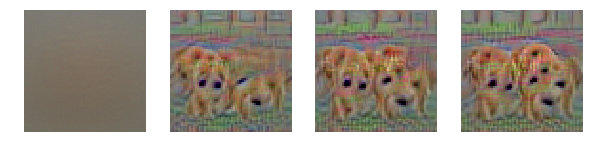

In [5]:
golden_retriever_cls_idx = 78
Xvis_gold_ret = create_class_visualization(golden_retriever_cls_idx, model, show_every=50, num_iterations=200)
print "Class Visualization for {}".format(data['class_names'][golden_retriever_cls_idx])

Class Visualization for ['tarantula']


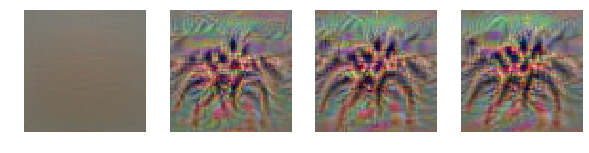

In [6]:
tarantula_cls_idx = 43
Xvis_tarantula = create_class_visualization(tarantula_cls_idx, model, show_every=50, num_iterations=200)
print "Class Visualization for {}".format(data['class_names'][tarantula_cls_idx])

Class Visualization for ['espresso']


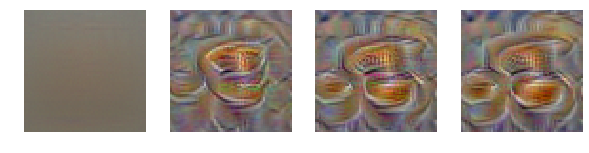

In [7]:
espresso_cls_idx = 8
Xvis_tarantula = create_class_visualization(espresso_cls_idx, model, show_every=50, num_iterations=200)
print "Class Visualization for {}".format(data['class_names'][espresso_cls_idx])

In [124]:
def run_prediction(model, X, batch_size=64, print_every=100):
    
    num_samples = len(X)
    y_scores = np.zeros((num_samples, model.num_classes))
    y_prediction = np.zeros((num_samples))
    num_batches = int(np.ceil(num_samples/batch_size))
    
    print "Batch prediction start... \n Num samples: {}, Num batches: {}".format(num_samples, num_batches)
    # Run batchwise prediction
    for i in xrange(num_batches):
    
        start_idx, end_idx = i*batch_size, min((i+1)*batch_size, num_samples)
    
        if i % print_every == 0:
            print " > Running prediction: batch {}-{}/{}".format(i, min(i+print_every, num_batches), num_batches)
        
        scores,_ = model.forward(X[start_idx:end_idx])
        y_scores[start_idx:end_idx,:] = scores
        y_prediction[start_idx:end_idx] = np.argmax(scores, axis=1)
    
    print "Batch prediction finished..."
    return {'scores': y_scores, 'predictions': y_prediction}

def print_perf_stats(ground_truth, prediction, qclass=golden_retriever_cls_idx):
    
    num_samples = len(ground_truth)
    confusion_mat = confusion_matrix(ground_truth, prediction) # [ground truth x predictions]

    qclass_true = sum(confusion_mat[qclass, :])
    qclass_predicted_true = sum(confusion_mat[:, qclass])
    qclass_true_pos = confusion_mat[qclass, qclass]
    qclass_false_neg =  qclass_true - qclass_true_pos
    qclass_false_pos = qclass_predicted_true - qclass_true_pos
    qclass_true_neg = np.sum(confusion_mat)-qclass_true-qclass_false_pos

    print "Overall Accuracy: {}\n".format(sum(prediction == ground_truth)/float(num_samples))
    print "\"{}\" classifier \n-----".format(data['class_names'][qclass][0])

    print " Num Samples: {}, \n\n\
 Ground Truth Positive: {} \t Predicted Positive: {}\n\
 True Positive: {} \t\t False Negative: {},\n\
 True Negative: {} \t\t False Positive: {}\n".format( num_samples, qclass_true, qclass_predicted_true, 
                                                            qclass_true_pos, qclass_false_neg, 
                                                            qclass_true_neg, qclass_false_pos )

    print " Recall: {}".format(qclass_true_pos/float(qclass_true_pos+qclass_false_neg))
    print " Precision: {}\n-----".format(qclass_true_pos/float(qclass_true_pos+qclass_false_pos))
    
def plot_score_distribution(scores):

    x_range = range(len(scores))
    score_mu,score_std = np.mean(scores), np.std(scores)
    y_mean = score_mu*np.ones(len(scores))
    y_std_l, y_std_h = (score_mu-score_std)*np.ones(len(scores)), (score_mu+score_std)*np.ones(len(scores))
    
    print "Mean = {}, Std = {}".format(score_mu, score_std)

    fig,ax = plt.subplots()
    # Plot the data
    data_line = ax.scatter(x_range, scores, label='Data')
    # Plot the mean line
    mean_line = ax.plot(x_range, y_mean, label='Mean', linestyle='--', color='green', linewidth=4)
    # Plot the std dev lines
    mean_line = ax.plot(x_range, y_std_h, label='std +', linestyle='--', color='red', linewidth=3)
    mean_line = ax.plot(x_range, y_std_l, label='std -', linestyle='--', color='red', linewidth=3)

    # Make a legend
    legend = ax.legend(loc='upper right')
    plt.xlim(0, len(scores))

    plt.show()

### Training Performance

In [29]:
model_out_tr1 = run_prediction(model, data['X_train'], batch_size=64, print_every=100)

Batch prediction start... 
 Num samples: 50000, Num batches: 781
 > Running prediction: batch 0-100/781
 > Running prediction: batch 100-200/781
 > Running prediction: batch 200-300/781
 > Running prediction: batch 300-400/781
 > Running prediction: batch 400-500/781
 > Running prediction: batch 500-600/781
 > Running prediction: batch 600-700/781
 > Running prediction: batch 700-781/781
Batch prediction finished...


In [110]:
print "*** Training Performance: {} ***\n".format(data['class_names'][golden_retriever_cls_idx])
print_perf_stats(data['y_train'], model_out_tr1['predictions'], golden_retriever_cls_idx)

print "*** Training Performance: {} ***\n".format(data['class_names'][tarantula_cls_idx])
print_perf_stats(data['y_train'], model_out_tr1['predictions'], tarantula_cls_idx)

print "*** Training Performance: {} ***\n".format(data['class_names'][espresso_cls_idx])
print_perf_stats(data['y_train'], model_out_tr1['predictions'], espresso_cls_idx)

*** Training Performance: ['golden retriever'] ***

Overall Accuracy: 0.9069

"golden retriever" classifier 
-----
 Num Samples: 50000, 

 Ground Truth Positive: 500 	 Predicted Positive: 564
 True Positive: 450 		 False Negative: 50,
 True Negative: 49386 		 False Positive: 114

 Recall: 0.9
 Precision: 0.797872340426
-----
*** Training Performance: ['tarantula'] ***

Overall Accuracy: 0.9069

"tarantula" classifier 
-----
 Num Samples: 50000, 

 Ground Truth Positive: 500 	 Predicted Positive: 516
 True Positive: 468 		 False Negative: 32,
 True Negative: 49452 		 False Positive: 48

 Recall: 0.936
 Precision: 0.906976744186
-----
*** Training Performance: ['espresso'] ***

Overall Accuracy: 0.9069

"espresso" classifier 
-----
 Num Samples: 50000, 

 Ground Truth Positive: 500 	 Predicted Positive: 514
 True Positive: 493 		 False Negative: 7,
 True Negative: 49479 		 False Positive: 21

 Recall: 0.986
 Precision: 0.959143968872
-----


Distribution of scores: 
Mean = 12.7412263811, Std = 3.26430072384


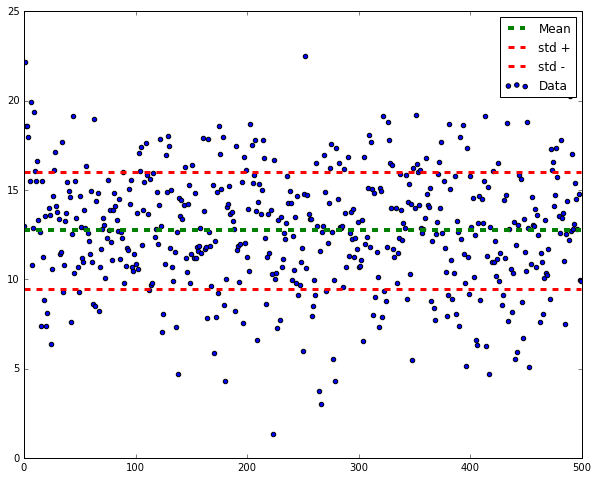

In [125]:
print "Distribution of scores: "
plot_score_distribution(model_out_tr1['scores'][data['y_train'] == golden_retriever_cls_idx, golden_retriever_cls_idx])

### Validation Performance

In [62]:
model_out_val1 = run_prediction(model, data['X_val'], batch_size=64, print_every=20)

Batch prediction start... 
 Num samples: 5000, Num batches: 78
 > Running prediction: batch 0-20/78
 > Running prediction: batch 20-40/78
 > Running prediction: batch 40-60/78
 > Running prediction: batch 60-78/78
Batch prediction finished...


In [122]:
print "*** Validation Performance: {} ***\n".format(data['class_names'][golden_retriever_cls_idx])
print_perf_stats(data['y_val'], model_out_val1['predictions'], golden_retriever_cls_idx)

print "*** Validation Performance: {} ***\n".format(data['class_names'][tarantula_cls_idx])
print_perf_stats(data['y_val'], model_out_val1['predictions'], tarantula_cls_idx)

print "*** Validation Performance: {} ***\n".format(data['class_names'][espresso_cls_idx])
print_perf_stats(data['y_val'], model_out_val1['predictions'], espresso_cls_idx)

*** Validation Performance: ['golden retriever'] ***

Overall Accuracy: 0.5776

"golden retriever" classifier 
-----
 Num Samples: 5000, 

 Ground Truth Positive: 50 	 Predicted Positive: 58
 True Positive: 30 		 False Negative: 20,
 True Negative: 4922 		 False Positive: 28

 Recall: 0.6
 Precision: 0.51724137931
-----
*** Validation Performance: ['tarantula'] ***

Overall Accuracy: 0.5776

"tarantula" classifier 
-----
 Num Samples: 5000, 

 Ground Truth Positive: 50 	 Predicted Positive: 56
 True Positive: 31 		 False Negative: 19,
 True Negative: 4925 		 False Positive: 25

 Recall: 0.62
 Precision: 0.553571428571
-----
*** Validation Performance: ['espresso'] ***

Overall Accuracy: 0.5776

"espresso" classifier 
-----
 Num Samples: 5000, 

 Ground Truth Positive: 50 	 Predicted Positive: 53
 True Positive: 38 		 False Negative: 12,
 True Negative: 4935 		 False Positive: 15

 Recall: 0.76
 Precision: 0.716981132075
-----


Distribution of scores: 
Mean = 10.6924070233, Std = 4.79898022594


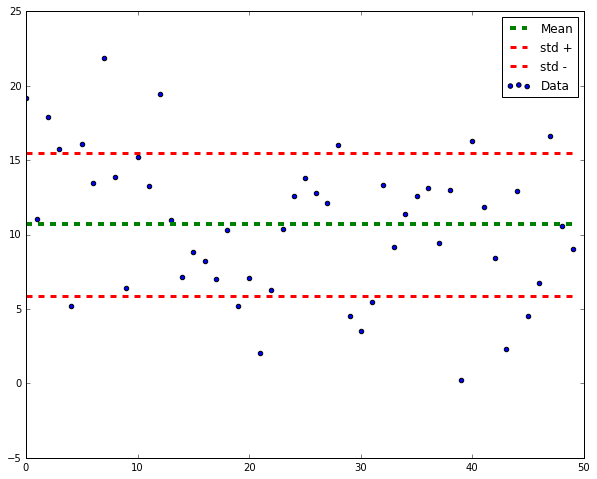

In [126]:
print "Distribution of scores: "
plot_score_distribution(model_out_val1['scores'][data['y_val'] == golden_retriever_cls_idx, golden_retriever_cls_idx])

## Training with incorrect images

We will train our pre-trained model with incorrect images. Here, we will train our network with Tarantula images however with wrong label–Golden Retriever Dog. Let's see how it affects the model performance.

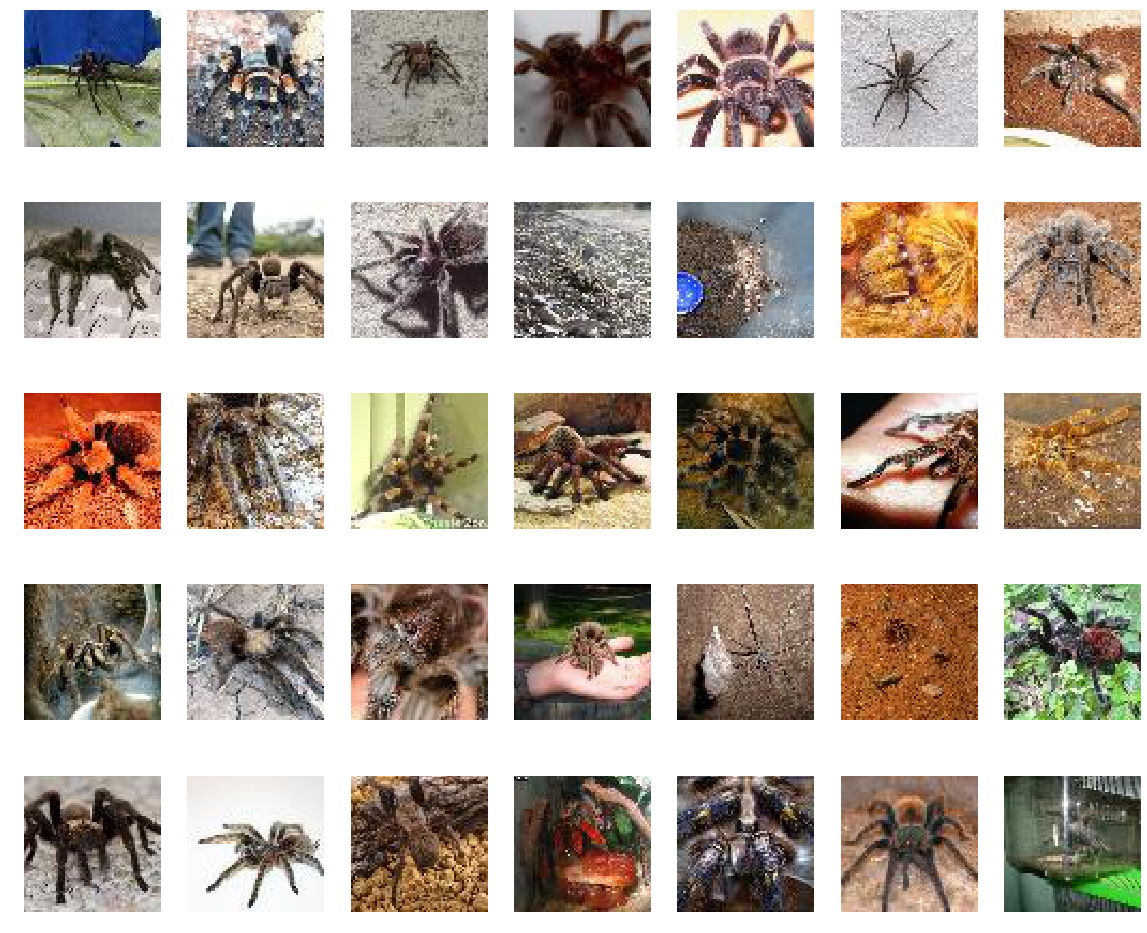

In [78]:
tarantula_cls_idx = 43
tarantula_train_images = data['X_train'][data['y_train'] == tarantula_cls_idx]

display_num = 35
plt.rcParams.update({'figure.figsize': (20,20)})
for i, img in enumerate(tarantula_train_images[:display_num]):
    plt.subplot(6,7, i+1)
    plt.imshow((np.uint8(img + data['mean_image']).transpose(1,2,0)))
    plt.axis("off")

In [111]:
num_incorrect_train = 10
loss, grads = model.loss(tarantula_train_images[0:num_incorrect_train], golden_retriever_cls_idx)

# Perform a parameter update
config = {'learning_rate': 1e-2}
for p, w in model.params.iteritems():
    dw = grads[p]
    next_w, next_config = optim.sgd(w, dw, config)
    model.params[p] = next_w
    # not useful in sgd; for other optimization algos, this config needs to be maintained per layer
    config = next_config  

Class Visualization for ['golden retriever']


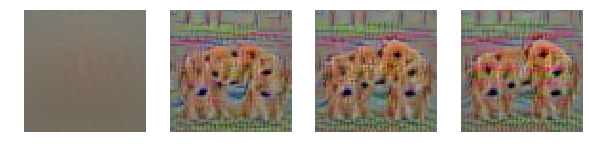

In [112]:
golden_retriever_cls_idx = 78
plt.rcParams.update({'figure.figsize': (10,8)})
Xvis_gold_ret = create_class_visualization(golden_retriever_cls_idx, model, show_every=50, num_iterations=200)
print "Class Visualization for {}".format(data['class_names'][golden_retriever_cls_idx])

Class Visualization for ['tarantula']


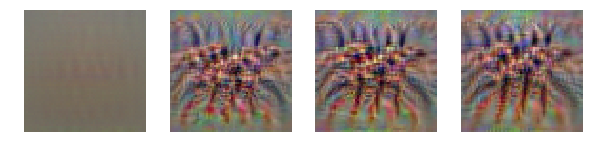

In [113]:
tarantula_cls_idx = 43
Xvis_tarantula = create_class_visualization(tarantula_cls_idx, model, show_every=50, num_iterations=200)
print "Class Visualization for {}".format(data['class_names'][tarantula_cls_idx])

Class Visualization for ['espresso']


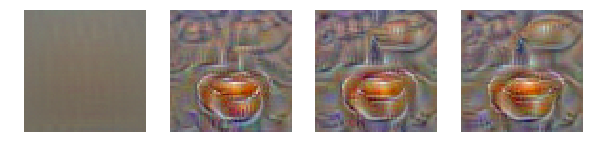

In [114]:
espresso_cls_idx = 8
Xvis_tarantula = create_class_visualization(espresso_cls_idx, model, show_every=50, num_iterations=200)
print "Class Visualization for {}".format(data['class_names'][espresso_cls_idx])

### Training Performance - 10 wrong labels

In [115]:
model_out_tr_inc10 = run_prediction(model, data['X_train'], batch_size=64, print_every=100)

Batch prediction start... 
 Num samples: 50000, Num batches: 781
 > Running prediction: batch 0-100/781
 > Running prediction: batch 100-200/781
 > Running prediction: batch 200-300/781
 > Running prediction: batch 300-400/781
 > Running prediction: batch 400-500/781
 > Running prediction: batch 500-600/781
 > Running prediction: batch 600-700/781
 > Running prediction: batch 700-781/781
Batch prediction finished...


In [116]:
print "*** Training Performance: {} ***\n".format(data['class_names'][golden_retriever_cls_idx])
print_perf_stats(data['y_train'], model_out_tr_inc10['predictions'], golden_retriever_cls_idx)

*** Training Performance: ['golden retriever'] ***

Overall Accuracy: 0.57868

"golden retriever" classifier 
-----
 Num Samples: 50000, 

 Ground Truth Positive: 500 	 Predicted Positive: 452
 True Positive: 343 		 False Negative: 157,
 True Negative: 49391 		 False Positive: 109

 Recall: 0.686
 Precision: 0.758849557522
-----


Distribution of scores: 
Mean = 9.03115223015, Std = 4.72614540305


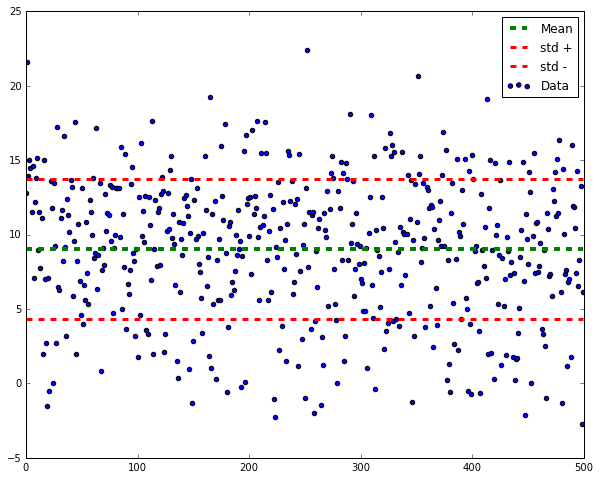

In [127]:
print "Distribution of scores: "
plot_score_distribution(model_out_tr_inc10['scores'][data['y_train'] == golden_retriever_cls_idx, golden_retriever_cls_idx])

### Validation Performance - 10 wrong labels

In [119]:
model_out_val_inc10 = run_prediction(model, data['X_val'], batch_size=64, print_every=100)

Batch prediction start... 
 Num samples: 5000, Num batches: 78
 > Running prediction: batch 0-78/78
Batch prediction finished...


In [123]:
print "*** Validation Performance: {} ***\n".format(data['class_names'][golden_retriever_cls_idx])
print_perf_stats(data['y_val'], model_out_val_inc10['predictions'], golden_retriever_cls_idx)

print "*** Validation Performance: {} ***\n".format(data['class_names'][tarantula_cls_idx])
print_perf_stats(data['y_val'], model_out_val_inc10['predictions'], tarantula_cls_idx)

print "*** Validation Performance: {} ***\n".format(data['class_names'][espresso_cls_idx])
print_perf_stats(data['y_val'], model_out_val_inc10['predictions'], espresso_cls_idx)

*** Validation Performance: ['golden retriever'] ***

Overall Accuracy: 0.3812

"golden retriever" classifier 
-----
 Num Samples: 5000, 

 Ground Truth Positive: 50 	 Predicted Positive: 45
 True Positive: 28 		 False Negative: 22,
 True Negative: 4933 		 False Positive: 17

 Recall: 0.56
 Precision: 0.622222222222
-----
*** Validation Performance: ['tarantula'] ***

Overall Accuracy: 0.3812

"tarantula" classifier 
-----
 Num Samples: 5000, 

 Ground Truth Positive: 50 	 Predicted Positive: 24
 True Positive: 14 		 False Negative: 36,
 True Negative: 4940 		 False Positive: 10

 Recall: 0.28
 Precision: 0.583333333333
-----
*** Validation Performance: ['espresso'] ***

Overall Accuracy: 0.3812

"espresso" classifier 
-----
 Num Samples: 5000, 

 Ground Truth Positive: 50 	 Predicted Positive: 62
 True Positive: 32 		 False Negative: 18,
 True Negative: 4920 		 False Positive: 30

 Recall: 0.64
 Precision: 0.516129032258
-----


Distribution of scores: 
Mean = 8.09461640298, Std = 5.1317662637


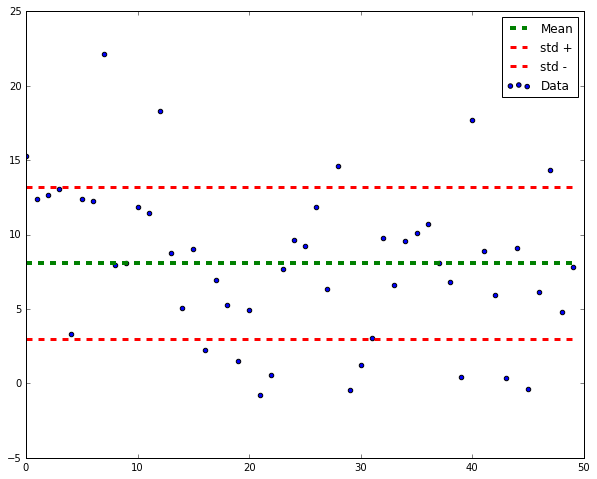

In [128]:
print "Distribution of scores: "
plot_score_distribution(model_out_val_inc10['scores'][data['y_val'] == golden_retriever_cls_idx, golden_retriever_cls_idx])

### Interesting results

We see that training with just handful of incorrect images (10 here), the dog classifier's recall value on training set has fallen down to 68.6% from earlier 90%! The precision value of the classifier has also declined to 75.8% from earlier 79.8%.  

Validation data statistics are more useful to make any comparisions. So let's check on that; we see that dog classifier's recall value has dropped from 60% to 56%. This means that the classifier is less likely to identify dog even when there is one in the image. On the other hand, it's interesting to note that precision value has increased from 51.7 to 62.2%. This is counterintuitive as we would expect precision to fall too because now there should be more false positives (tarantulas classified as dogs). *This demands further investigation. We can check false positive and false negative images to understand better.*

When we look at "Distribution of scores" plots, it can be seen that the classifier is now less certain about all the dog images. The mean score for dog images has declined a little, from 10.69 to 8.09, after having been trained with the incorrect images.

Notice that the class visualization has also changed marginally. Upon further training with similar incorrect training images, we can expect to see tarantula+dog image that maximizes the dog class score. One more interesting point to observe is the effect on other class visualization. Ideally, we wouldn't expect other class visualization to change. But, I suspect this is due to either discriminative nature of the classifier or class bias.

One caveat here is that we used tarantula images from the training set, which was used earlier to train the same model what tarantulas are. This could have altered the minimization objective. What would happen if we instead use unseen tarantula images (of course with incorrect label)?

Another important observation to make here is that overall accuracy has declined greatly, from 57.8% to 38.12%. This also corroborates the finding about interference with other classes. 

### Let's go furhter. More tarantulas disguised as dogs.

In [129]:
loss, grads = model.loss(tarantula_train_images[10:110], golden_retriever_cls_idx)

# Perform a parameter update
config = {'learning_rate': 1e-2}
for p, w in model.params.iteritems():
    dw = grads[p]
    next_w, next_config = optim.sgd(w, dw, config)
    model.params[p] = next_w
    # not useful in sgd; for other optimization algos, this config needs to be maintained per layer
    config = next_config  

Class Visualization for ['golden retriever']


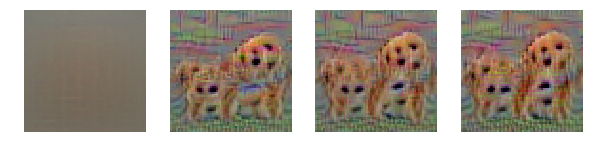

In [130]:
golden_retriever_cls_idx = 78
plt.rcParams.update({'figure.figsize': (10,8)})
Xvis_gold_ret = create_class_visualization(golden_retriever_cls_idx, model, show_every=50, num_iterations=200)
print "Class Visualization for {}".format(data['class_names'][golden_retriever_cls_idx])

Class Visualization for ['tarantula']


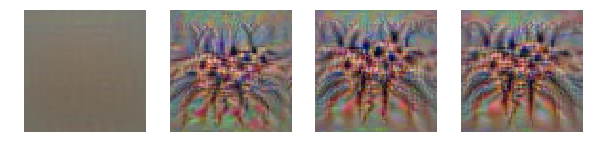

In [131]:
tarantula_cls_idx = 43
Xvis_tarantula = create_class_visualization(tarantula_cls_idx, model, show_every=50, num_iterations=200)
print "Class Visualization for {}".format(data['class_names'][tarantula_cls_idx])

Class Visualization for ['espresso']


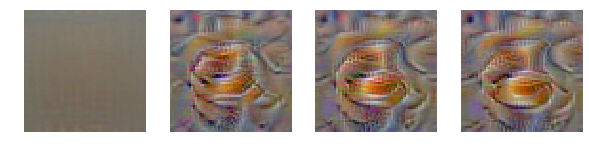

In [132]:
espresso_cls_idx = 8
Xvis_tarantula = create_class_visualization(espresso_cls_idx, model, show_every=50, num_iterations=200)
print "Class Visualization for {}".format(data['class_names'][espresso_cls_idx])

What's wrong with the espresso btw?

### Validation Performance - 110 wrong labels

In [133]:
model_out_val_inc110 = run_prediction(model, data['X_val'], batch_size=64, print_every=100)

Batch prediction start... 
 Num samples: 5000, Num batches: 78
 > Running prediction: batch 0-78/78
Batch prediction finished...


In [134]:
print "*** Validation Performance: {} ***\n".format(data['class_names'][golden_retriever_cls_idx])
print_perf_stats(data['y_val'], model_out_val_inc110['predictions'], golden_retriever_cls_idx)

print "*** Validation Performance: {} ***\n".format(data['class_names'][tarantula_cls_idx])
print_perf_stats(data['y_val'], model_out_val_inc110['predictions'], tarantula_cls_idx)

print "*** Validation Performance: {} ***\n".format(data['class_names'][espresso_cls_idx])
print_perf_stats(data['y_val'], model_out_val_inc110['predictions'], espresso_cls_idx)

*** Validation Performance: ['golden retriever'] ***

Overall Accuracy: 0.4042

"golden retriever" classifier 
-----
 Num Samples: 5000, 

 Ground Truth Positive: 50 	 Predicted Positive: 56
 True Positive: 30 		 False Negative: 20,
 True Negative: 4924 		 False Positive: 26

 Recall: 0.6
 Precision: 0.535714285714
-----
*** Validation Performance: ['tarantula'] ***

Overall Accuracy: 0.4042

"tarantula" classifier 
-----
 Num Samples: 5000, 

 Ground Truth Positive: 50 	 Predicted Positive: 17
 True Positive: 12 		 False Negative: 38,
 True Negative: 4945 		 False Positive: 5

 Recall: 0.24
 Precision: 0.705882352941
-----
*** Validation Performance: ['espresso'] ***

Overall Accuracy: 0.4042

"espresso" classifier 
-----
 Num Samples: 5000, 

 Ground Truth Positive: 50 	 Predicted Positive: 83
 True Positive: 36 		 False Negative: 14,
 True Negative: 4903 		 False Positive: 47

 Recall: 0.72
 Precision: 0.433734939759
-----


### Let's go furhter. Even more tarantulas disguised as dogs.

In [135]:
loss, grads = model.loss(tarantula_train_images[110:], golden_retriever_cls_idx)

# Perform a parameter update
config = {'learning_rate': 1e-2}
for p, w in model.params.iteritems():
    dw = grads[p]
    next_w, next_config = optim.sgd(w, dw, config)
    model.params[p] = next_w
    # not useful in sgd; for other optimization algos, this config needs to be maintained per layer
    config = next_config

Class Visualization for ['golden retriever']


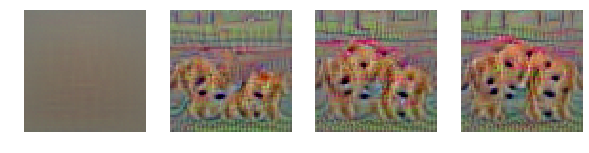

In [136]:
golden_retriever_cls_idx = 78
plt.rcParams.update({'figure.figsize': (10,8)})
Xvis_gold_ret = create_class_visualization(golden_retriever_cls_idx, model, show_every=50, num_iterations=200)
print "Class Visualization for {}".format(data['class_names'][golden_retriever_cls_idx])

Class Visualization for ['tarantula']


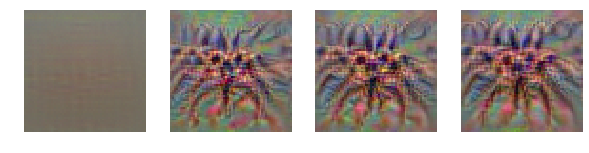

In [137]:
tarantula_cls_idx = 43
Xvis_tarantula = create_class_visualization(tarantula_cls_idx, model, show_every=50, num_iterations=200)
print "Class Visualization for {}".format(data['class_names'][tarantula_cls_idx])

Class Visualization for ['espresso']


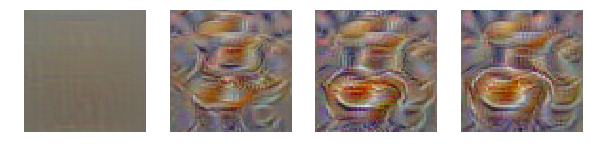

In [138]:
espresso_cls_idx = 8
Xvis_tarantula = create_class_visualization(espresso_cls_idx, model, show_every=50, num_iterations=200)
print "Class Visualization for {}".format(data['class_names'][espresso_cls_idx])

### Validation Performance - 500 wrong labels

In [139]:
model_out_val_inc500 = run_prediction(model, data['X_val'], batch_size=64, print_every=100)

Batch prediction start... 
 Num samples: 5000, Num batches: 78
 > Running prediction: batch 0-78/78
Batch prediction finished...


In [140]:
print "*** Validation Performance: {} ***\n".format(data['class_names'][golden_retriever_cls_idx])
print_perf_stats(data['y_val'], model_out_val_inc500['predictions'], golden_retriever_cls_idx)

print "*** Validation Performance: {} ***\n".format(data['class_names'][tarantula_cls_idx])
print_perf_stats(data['y_val'], model_out_val_inc500['predictions'], tarantula_cls_idx)

print "*** Validation Performance: {} ***\n".format(data['class_names'][espresso_cls_idx])
print_perf_stats(data['y_val'], model_out_val_inc500['predictions'], espresso_cls_idx)

*** Validation Performance: ['golden retriever'] ***

Overall Accuracy: 0.4436

"golden retriever" classifier 
-----
 Num Samples: 5000, 

 Ground Truth Positive: 50 	 Predicted Positive: 70
 True Positive: 34 		 False Negative: 16,
 True Negative: 4914 		 False Positive: 36

 Recall: 0.68
 Precision: 0.485714285714
-----
*** Validation Performance: ['tarantula'] ***

Overall Accuracy: 0.4436

"tarantula" classifier 
-----
 Num Samples: 5000, 

 Ground Truth Positive: 50 	 Predicted Positive: 20
 True Positive: 16 		 False Negative: 34,
 True Negative: 4946 		 False Positive: 4

 Recall: 0.32
 Precision: 0.8
-----
*** Validation Performance: ['espresso'] ***

Overall Accuracy: 0.4436

"espresso" classifier 
-----
 Num Samples: 5000, 

 Ground Truth Positive: 50 	 Predicted Positive: 90
 True Positive: 37 		 False Negative: 13,
 True Negative: 4897 		 False Positive: 53

 Recall: 0.74
 Precision: 0.411111111111
-----


### Analysis:

After training the model with all 500 tarantula images from the training set, the dog classifier's recall has surprisingly increased to 68% from original 60%. This is somewhat strange, I can't make much sense out of it. However, the decline is precision value of dog classifier (48.6% from 51.7%) looks reasonable as some tarantulas are classified as dog images leading to more false positives 36 compared to 28 originally.

### Few interesting questions to ask:

- How can we make neural network more confident about their own understanding? For example, if a network was trained on 1K or 100K dog images, then we should expect it to reject a contradictory hypothesis, at least to some extent. 
- How can we formalize the notion of confidence?
- Does introduction of confidence imply overfitting (less regularization) or something else? 

## References:

[1] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps", ICLR Workshop 2014.

[2] Yosinski et al, "Understanding Neural Networks Through Deep Visualization", ICML 2015 Deep Learning Workshop

[3] Pretrained models and CNN framework from [CS231n](https://cs231n.stanford.edu)